In [2]:
import os
import random
import imageio
import glob
import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

from keras import layers
from keras import models
from keras.models import Model




from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you

In [9]:
#Function to get the paths from the directory

def get_files(base_dir, ext=None):
    assert type(ext) in [list, str]
    ext = [ext] if type(ext)!= list else ext
    ret_files = []
    
    for f in glob.glob(f'{base_dir}/**', recursive=True):
        if (ext is not None) and not any([f.endswith(e) for e in ext]):
            continue
        ret_files.append(f)
        
    return ret_files

In [10]:
#Get paths and labels

root_directory = "data\\dataset_2_final\\"
class_names = sorted([f for f in os.listdir(root_directory) if not f.startswith('.')])
class2int = dict(zip(class_names, range(len(class_names))))
num_classes = len(class_names)
image_paths = get_files(root_directory, 'jpg')
labels = list(map(lambda im: class2int[im.split(root_directory)[1].split('\\')[0]], image_paths))
np.unique(labels, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 78,  70,  67, 124,  69,  69,  71], dtype=int64))

In [11]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=8, image_size=255, shuffle_epoch=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle_epoch = shuffle_epoch
        
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        
        if (idx == 0) and (self.shuffle_epoch):            
            # Shuffle at first batch
            c = list(zip(self.images, self.labels))
            random.shuffle(c)
            self.images, self.labels = zip(*c)
            self.images, self.labels = np.array(self.images), np.array(self.labels)       
        
        images = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        # Read images
        images = np.array([imageio.v2.imread(im) for im in images])
        
        # Choose one of the four quadrants
        x, y = np.random.choice([0,1], size=2)
        images = images[:,(x*600):(x*600 + 600), (y*800):(y*800 + 800)]
        
        #Todos los modelos tienen capa de rescaling por lo que no es necesaria aqui
        # images = images/255
        
        images = np.array([self.random_crop(im) for im in images])
        labels = to_categorical(labels, num_classes=num_classes)
        
        return images, labels
    
    def random_crop(self, image):
        cropped_image = tf.image.random_crop(image, size=[self.image_size, self.image_size, 3]).numpy()
        return cropped_image


For reference: 

- Private images are 1600x1200 (800 x 600 when splitted)
- Public images are 768 x 768

In [12]:
#Split in training and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


#Build the generators
train_generator = CustomDataGenerator(train_paths, train_labels)
val_generator = CustomDataGenerator(val_paths, val_labels, shuffle_epoch=False)


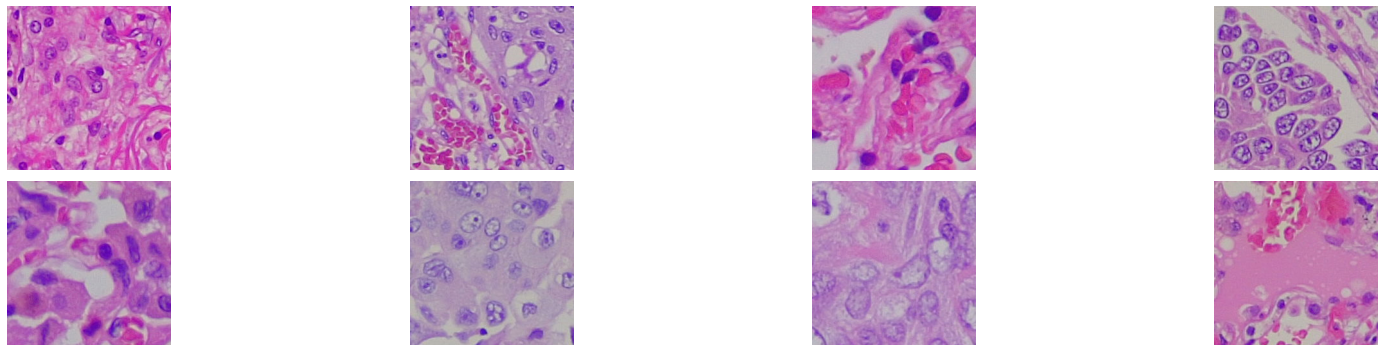

In [13]:
fig, axs = plt.subplots(2,4, figsize=(25,5))
axs = axs.flatten()

for i in range(8):
    gen = train_generator if i<4 else val_generator
    axs[i].imshow(gen[1][0][i%10])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [14]:
labels = np.concatenate([l.argmax(1) for _, l in tqdm(gen, leave=False)])
class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(labels),
                                                     y=list(labels))
class_weights = dict(enumerate(class_weights))
class_weights

  0%|          | 0/14 [00:00<?, ?it/s]

{0: 0.7142857142857143,
 1: 1.1224489795918366,
 2: 1.2087912087912087,
 3: 0.7142857142857143,
 4: 1.2087912087912087,
 5: 1.746031746031746,
 6: 0.9243697478991597}

In [15]:
#function to plot the metrics of the trainign and validation

def plot_metrics(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['metrics/accuracy'], label='Train')
    plt.plot(history.history['val_metrics/accuracy'], label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def test_model(model):

    test_directory = "data\\validation_final_septiembre\\"
    test_image_paths = get_files(test_directory, 'jpg')
    test_labels = [class2int[im.split(test_directory)[1].split('\\')[0]] for im in test_image_paths]

    test_generator = CustomDataGenerator(test_image_paths, test_labels, shuffle_epoch=False)
    test_predictions = model.predict(test_generator)

    # Convert predictions to class labels
    predicted_labels = np.argmax(test_predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')

    print("Test Accuracy:", accuracy)
    print("Test Precision:", precision)
    print("Test Recall:", recall)



    # Obtain the confusion matrix
    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    # Ensure that labels are unique and match the confusion matrix
    labels = np.unique(np.concatenate((test_labels, predicted_labels)))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()


# EFFICIENTNET

In [24]:
base_model = EfficientNetB0(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomFlip("vertical"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),    
    preprocessing.RandomContrast(0.2),

])

# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 10 layers in the base model for fine-tuning
# for layer in base_model.layers[-5:]:
#     layer.trainable = True

#capa de entradas. 
entradas = layers.Input((255, 255, 3))

# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs = entradas, outputs = salidas)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 4,709,034
Trainable params: 4,667,011
Non-trainable params: 42,023
_________________________________________________________________


In [25]:
import datetime

In [26]:
MODEL_NAME = 'EfB1_7cat'
RUN_NAME = ''
log_dir = f'new_logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'


In [27]:
num_epochs = 140
patience = 50
patience_lr = 5

model1.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [28]:
# Train the model using the custom data generators and the debugging callback
history = model1.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

Epoch 1/140
55/55 [==============================] - 127s 2s/step - loss: 1.7925 - metrics/accuracy: 0.3539 - metrics/top-3-accuracy: 0.6530 - metrics/F1-macro: 0.3218 - metrics/AUC: 0.7117 - metrics/precision: 0.5915 - metrics/recall: 0.1918 - metrics/P@R_99: 0.1509 - metrics/P@R_95: 0.1635 - metrics/P@R_90: 0.1850 - metrics/MCC: 0.2373 - val_loss: 4.7724 - val_metrics/accuracy: 0.0909 - val_metrics/top-3-accuracy: 0.4273 - val_metrics/F1-macro: 0.0347 - val_metrics/AUC: 0.5880 - val_metrics/precision: 0.0926 - val_metrics/recall: 0.0909 - val_metrics/P@R_99: 0.1429 - val_metrics/P@R_95: 0.1429 - val_metrics/P@R_90: 0.1429 - val_metrics/MCC: 0.0035
Epoch 2/140
55/55 [==============================] - 84s 2s/step - loss: 1.8738 - metrics/accuracy: 0.3676 - metrics/top-3-accuracy: 0.6735 - metrics/F1-macro: 0.3236 - metrics/AUC: 0.7030 - metrics/precision: 0.5000 - metrics/recall: 0.1530 - metrics/P@R_99: 0.1429 - metrics/P@R_95: 0.1675 - metrics/P@R_90: 0.1783 - metrics/MCC: 0.2525 - v

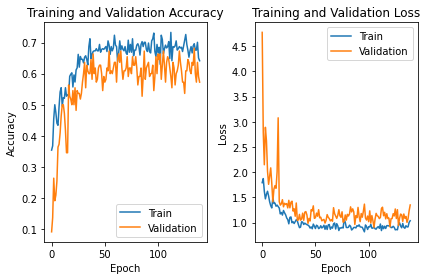

In [29]:
#Plot metrics
plot_metrics(history)

### Test

Test Accuracy: 0.35714285714285715
Test Precision: 0.36573347287633
Test Recall: 0.35714285714285715


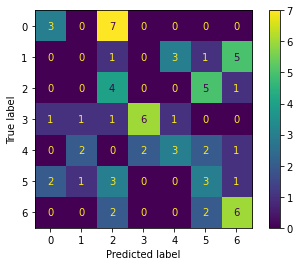

In [30]:
test_model(model1)

For dubug purposes only. I load a model that is trained already

In [31]:
# !tensorboard --logdir=C:\Users\diosdadj\OneDrive - HP Inc\Master\Lung Cancer Project\lung_tissues_classification\logs

# RESNET 50

In [17]:
base_model = ResNet50(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
])

# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 2 layers in the base model for fine-tuning
# for layer in base_model.layers[-2:]:
#     layer.trainable = True

#capa de entradas. 
entradas = layers.Input((255, 255, 3))

# Rescaling layer to scale pixel values between 0 and 1
x = Rescaling(scale=1./255)(entradas)

# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs = entradas, outputs = salidas)
model2.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 24,640,391
Trainable params: 24,587,271
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
num_epochs = 80
patience = 20
patience_lr = 10

model2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [19]:
import datetime

In [20]:
MODEL_NAME = 'R50'
RUN_NAME = ''
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'

In [21]:
# Train the model using the custom data generators and the debugging callback
history = model2.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/80
55/55 [==============================] - 221s 4s/step - loss: 2.2213 - metrics/accuracy: 0.2009 - metrics/top-3-accuracy: 0.5183 - metrics/F1-macro: 0.1765 - metrics/AUC: 0.5661 - metrics/precision: 0.2500 - metrics/recall: 0.0365 - metrics/P@R_99: 0.1429 - metrics/P@R_95: 0.1452 - metrics/P@R_90: 0.1462 - metrics/MCC: 0.0812 - val_loss: 8529.0332 - val_metrics/accuracy: 0.0818 - val_metrics/top-3-accuracy: 1.0000 - val_metrics/F1-macro: 0.0216 - val_metrics/AUC: 0.5000 - val_metrics/precision: 0.0818 - val_metrics/recall: 0.0818 - val_metrics/P@R_99: 0.0000e+00 - val_metrics/P@R_95: 0.0000e+00 - val_metrics/P@R_90: 0.0000e+00 - val_metrics/MCC: 0.0000e+00
Epoch 2/80
55/55 [==============================] - 153s 3s/step - loss: 1.8715 - metrics/accuracy: 0.3037 - metrics/top-3-accuracy: 0.6301 - metrics/F1-macro: 0.2506 - metrics/AUC: 0.6517 - metrics/precision: 0.4605 - metrics/recall: 0.0799 - metrics/P@R_99: 0.1537 - metrics/P@R_95: 0.1587 - metrics/P@R_90: 0.1653 - metri

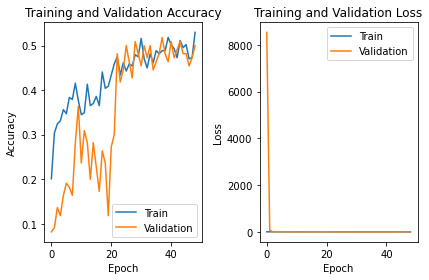

In [22]:
plot_metrics(history)

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.4
Test Precision: 0.43345701917130486
Test Recall: 0.39999999999999997


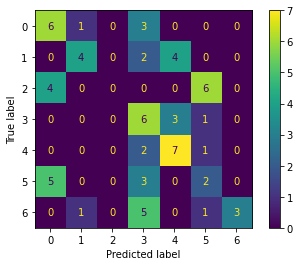

In [23]:
test_model(model2)

# CNN

In [36]:
input_shape = (255, 255, 3)


model3=models.Sequential()
model3.add(layers.Input(input_shape))
#Rescalling layer

model3.add(layers.Rescaling(scale=1./255))


model3.add(layers.RandomFlip("horizontal_and_vertical"))
model3.add(layers.RandomRotation(0.2))
model3.add(layers.RandomZoom(0.2))
model3.add(layers.RandomContrast(0.2))
model3.add(layers.RandomTranslation(0.2, 0.2))
# model.add(layers.RandomHeight(0.2))
# model.add(layers.RandomWidth(0.2))

model3.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Add flatten layer
model3.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model3.add(layers.Dense(512, activation = 'relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dropout(0.2))

model3.add(layers.Dense(num_classes, activation = 'softmax'))

adamop = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model3.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[115200,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [25]:
MODEL_NAME = 'CNN'
RUN_NAME = ''
log_dir = f'new_logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'

In [26]:
num_epochs = 80
patience = 20
patience_lr = 10

model3.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [28]:
# Train the model using the custom data generators and the debugging callback
history = model3.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

Epoch 1/80
55/55 [==============================] - 64s 1s/step - loss: 2.0414 - metrics/accuracy: 0.1301 - metrics/top-3-accuracy: 0.4406 - metrics/F1-macro: 0.0596 - metrics/AUC: 0.5129 - metrics/precision: 0.0000e+00 - metrics/recall: 0.0000e+00 - metrics/P@R_99: 0.1437 - metrics/P@R_95: 0.1458 - metrics/P@R_90: 0.1470 - metrics/MCC: -0.0202 - val_loss: 2.1482 - val_metrics/accuracy: 0.0818 - val_metrics/top-3-accuracy: 0.3636 - val_metrics/F1-macro: 0.0216 - val_metrics/AUC: 0.5650 - val_metrics/precision: 0.0000e+00 - val_metrics/recall: 0.0000e+00 - val_metrics/P@R_99: 0.1429 - val_metrics/P@R_95: 0.1429 - val_metrics/P@R_90: 0.1429 - val_metrics/MCC: 0.0000e+00
Epoch 2/80
55/55 [==============================] - 53s 953ms/step - loss: 2.0047 - metrics/accuracy: 0.1119 - metrics/top-3-accuracy: 0.4703 - metrics/F1-macro: 0.0398 - metrics/AUC: 0.5024 - metrics/precision: 0.0000e+00 - metrics/recall: 0.0000e+00 - metrics/P@R_99: 0.1446 - metrics/P@R_95: 0.1450 - metrics/P@R_90: 0.1

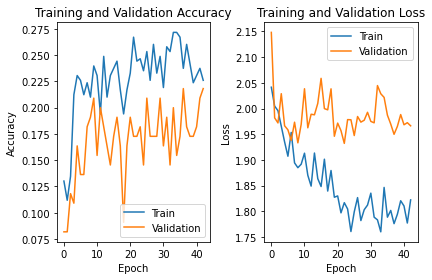

In [29]:
#plot metrics
plot_metrics(history)


### Test

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.2714285714285714
Test Precision: 0.14512471655328799
Test Recall: 0.2714285714285714


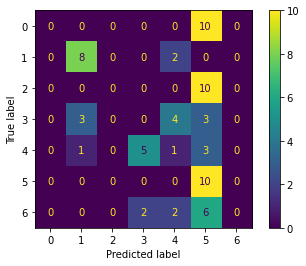

In [31]:
test_model(model3)